In [33]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import scienceplots
from src.styles import set_plot_style
from src.plots import *
from src.utils import load_and_prepare_metadata
set_plot_style("prism_rain")
from src.utils import _read_measurement

In [34]:
def plot_iv_overlay(
    df: pl.DataFrame,
    base_dir: Path,
    tag: str,
    *,
    vgs: list[float] | None = None,            # e.g. [0.0, -2.0]
    wavelengths: list[float] | None = None,    # e.g. [455.0]
    tol: float = 1e-6,                         # Vg match tolerance
    wl_tol: float = 1e-6,                      # wavelength match tolerance
    file_idx: list[int] | None = None,         # pick specific runs (the _NN number)
    source_files: list[str] | None = None,     # or exact filenames
    sessions: list[int] | None = None,         # or sessions
    legend_label: str = "Vg={VG_meta:g} V",    # legend text – uses row fields
    clip_vsd_min: float | None = None,         # crop x (e.g., -0.5)
    clip_vsd_max: float | None = None,         # crop x (e.g.,  0.5)
    xlim: tuple[float,float] | None = None,    # force x-lims if you want
    ylim: tuple[float,float] | None = None,    # force y-lims if you want
    dedup_labels: bool = False,                # hide repeated legend labels
):
    """
    Overlay I–V curves (Id vs VSD) for 'IV' procedure rows in the metadata.
    Filters: by Vg, wavelength, and/or explicit run selection. Labels are configurable.
    """
    iv_all = df.filter(pl.col("proc") == "IV").sort("file_idx")
    if iv_all.height == 0:
        print("[warn] no IV rows in metadata")
        return

    # Build selection mask (start with all True)
    mask = pl.lit(True)

    # Filter by Vg (metadata VG stored as 'VG_meta' earlier)
    if vgs is not None:
        mask = mask & pl.any_horizontal([
            (pl.col("VG_meta") - float(v)).abs() <= tol for v in vgs
        ])

    # Filter by wavelength
    if wavelengths is not None and "Laser wavelength" in iv_all.columns:
        mask = mask & pl.any_horizontal([
            (pl.col("Laser wavelength") - float(w)).abs() <= wl_tol for w in wavelengths
        ])

    # Explicit picks (all are ANDed with previous filters)
    if file_idx:
        mask = mask & pl.col("file_idx").is_in(file_idx)
    if source_files:
        mask = mask & pl.col("source_file").is_in(source_files)
    if sessions:
        mask = mask & pl.col("session").is_in(sessions)

    sel = iv_all.filter(mask).sort("file_idx")
    if sel.height == 0:
        print("[info] no IV rows matched your selection")
        return

    plt.figure()
    plotted = 0
    seen_labels = set()

    for row in sel.iter_rows(named=True):
        p = base_dir / row["source_file"]
        if not p.exists():
            print(f"[warn] missing file: {p}")
            continue

        d = _read_measurement(p)
        # Expect standardized columns VSD and I from _std_rename()
        if not {"VSD", "I"} <= set(d.columns):
            print(f"[warn] {p} lacks VSD/I; got {d.columns}")
            continue

        # Optional crop of x-data before plotting (for y autoscale on visible range)
        dd = d
        if (clip_vsd_min is not None) or (clip_vsd_max is not None):
            conds = []
            if clip_vsd_min is not None:
                conds.append(pl.col("VSD") >= float(clip_vsd_min))
            if clip_vsd_max is not None:
                conds.append(pl.col("VSD") <= float(clip_vsd_max))
            if conds:
                dd = d.filter(pl.all_horizontal(conds))

        if dd.height == 0:
            continue

        # Legend label (format can use any row field you have in metadata)
        lbl = legend_label.format(
            file_idx=int(row["file_idx"]),
            session=int(row["session"]),
            info=str(row.get("Information", "")),
            VG_meta=float(row.get("VG_meta", float("nan"))),
            wavelength=float(row.get("Laser wavelength", float("nan"))),
        )

        # Optionally hide duplicate labels
        plot_label = lbl
        if dedup_labels and lbl in seen_labels:
            plot_label = "_" + lbl  # matplotlib ignores labels starting with "_"
        else:
            seen_labels.add(lbl)

        plt.plot(dd["VSD"], dd["I"]*1e6, label=plot_label)
        plotted += 1

    if plotted == 0:
        print("[warn] no IV curves plotted")
        return

    # Axes
    if xlim is not None:
        plt.xlim(*xlim)
    elif (clip_vsd_min is not None) or (clip_vsd_max is not None):
        # If you cropped data, let x autoscale to cropped extent
        pass

    if ylim is not None:
        plt.ylim(*ylim)

    # Title (include chip and optional wavelength summary)
    chip_txt = f"Chip {int(df['Chip number'][0])}" if 'Chip number' in df.columns else "Chip"
    if "Laser wavelength" in sel.columns and sel["Laser wavelength"].drop_nulls().len() > 0:
        wl_used = float(sel["Laser wavelength"].drop_nulls().median())
        title_extra = f", λ≈{wl_used:.0f} nm"
    else:
        title_extra = ""

    plt.xlabel("VSD (V)")
    plt.ylabel("Current (µA)")
    plt.title(f"{chip_txt} — {title_extra}")
    plt.legend(fontsize=8)
    plt.tight_layout()

    out = FIG_DIR / f"{chip_txt.replace(' ', '')}_IV_overlay_{tag}.png"
    plt.savefig(out, dpi=200)
    print(f"saved {out}")


saved figs/Chip1_IV_overlay_Serbian_Graphene_metadata.png


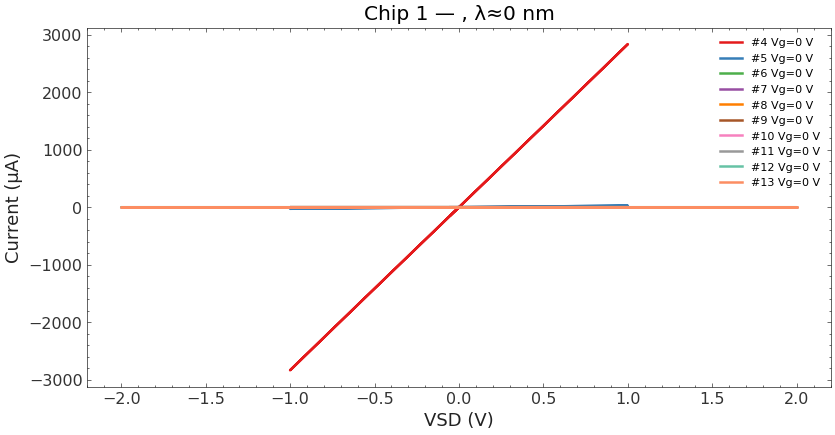

In [35]:
METADATA_CSV = "Serbian_Graphene_metadata.csv"        # path to the table you pasted
BASE_DIR     = Path(".")             # where the raw CSVs live, e.g. "Alisson_04_sept/"
CHIP_NUMBER  = 1.0 
meta = load_and_prepare_metadata(METADATA_CSV, CHIP_NUMBER)
tag = Path(METADATA_CSV).stem

plot_iv_overlay(meta, BASE_DIR, tag, legend_label="#{file_idx} Vg={VG_meta:g} V")

In [14]:
def plot_iv_selection_multi(
    picks: list[tuple[pl.DataFrame, Path, list[int]]],
    tag: str,
    *,
    legend_label: str = "Chip {chip} #{file_idx}",  # you can use: {chip}, {file_idx}, {VG_meta}, {wavelength}, {session}, {info}
    clip_vsd_min: float | None = None,
    clip_vsd_max: float | None = None,
    xlim: tuple[float, float] | None = None,
    ylim: tuple[float, float] | None = None,
    dedup_labels: bool = False,
):
    """
    Plot selected IV curves from multiple chips on ONE figure.

    picks = [
      (meta_df_for_chip_A, base_dir_for_chip_A, [idx1, idx2, ...]),
      (meta_df_for_chip_B, base_dir_for_chip_B, [idx3, ...]),
      ...
    ]
    """
    plt.figure()
    seen = set()
    total_plotted = 0

    for meta_df, base_dir, file_idxs in picks:
        iv_rows = (
            meta_df
            .filter((pl.col("proc") == "IV") & pl.col("file_idx").is_in(file_idxs))
            .sort("file_idx")
        )
        if iv_rows.height == 0:
            continue

        for row in iv_rows.iter_rows(named=True):
            p = base_dir / row["source_file"]
            if not p.exists():
                print(f"[warn] missing file: {p}")
                continue

            d = _read_measurement(p)
            if not {"VSD", "I"} <= set(d.columns):
                print(f"[warn] {p} lacks VSD/I; got {d.columns}")
                continue

            # optional crop so y autoscale matches the visible x-range
            dd = d
            if (clip_vsd_min is not None) or (clip_vsd_max is not None):
                conds = []
                if clip_vsd_min is not None:
                    conds.append(pl.col("VSD") >= float(clip_vsd_min))
                if clip_vsd_max is not None:
                    conds.append(pl.col("VSD") <= float(clip_vsd_max))
                if conds:
                    dd = d.filter(pl.all_horizontal(conds))
            if dd.height == 0:
                continue

            chip_num = int(row.get("Chip number", -1))
            lbl = legend_label.format(
                chip=chip_num,
                file_idx=int(row["file_idx"]),
                VG_meta=float(row.get("VG_meta", float("nan"))),
                wavelength=float(row.get("Laser wavelength", float("nan"))),
                session=int(row.get("session", -1)),
                info=str(row.get("Information", "")),
            )

            # de-dupe identical labels if requested
            plot_lbl = lbl
            if dedup_labels and lbl in seen:
                plot_lbl = "_" + lbl
            else:
                seen.add(lbl)

            plt.plot(dd["VSD"], dd["I"], label=plot_lbl)
            total_plotted += 1

    if total_plotted == 0:
        print("[warn] nothing plotted (check your file_idx picks)")
        return

    if xlim is not None:
        plt.xlim(*xlim)
    if ylim is not None:
        plt.ylim(*ylim)

    plt.xlabel("VSD (V)")
    plt.ylabel("Current (A)")
    plt.title("IV overlay — multi-chip selection")
    plt.legend(fontsize=8)
    plt.tight_layout()
    out = FIG_DIR / f"IV_overlay_multichip_{tag}.png"
    plt.savefig(out, dpi=200)
    print(f"saved {out}")


saved figs/IV_overlay_multichip_chip71_79_custom.png


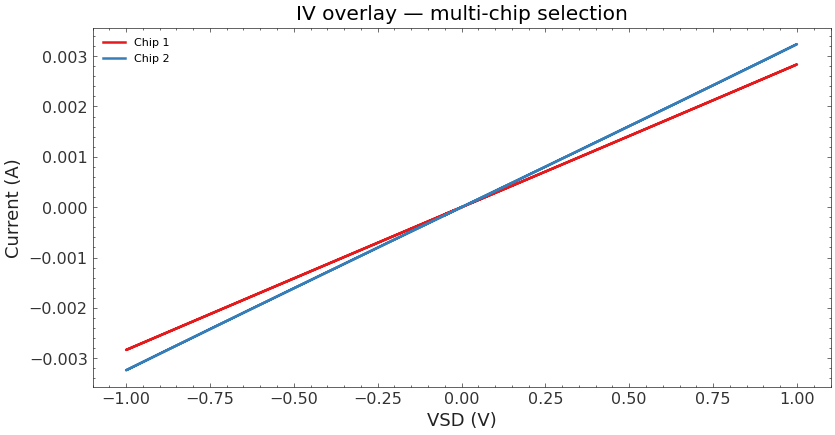

In [15]:
# Load each chip’s metadata separately (don’t filter by CHIP_NUMBER when loading,
# or call it twice, once per chip)
meta1 = load_and_prepare_metadata("Serbian_Graphene_metadata.csv", 1.0)
meta2 = load_and_prepare_metadata("Serbian_Graphene_metadata.csv", 2.0)

BASE1 = Path(".")
BASE2 = Path(".")
tag = "chip71_79_custom"

# Hand-pick IV runs by their _NN file indices per chip
picks = [
    (meta1, BASE1, [4]),   # from chip 71, plot IV #1 and #4
    (meta2, BASE2, [3]),   # from chip 79, plot IV #2 and #7
]

plot_iv_selection_multi(
    picks, tag,
    legend_label="Chip {chip}",   # legend shows chip number + file index
    dedup_labels=False
)

saved figs/Encap2_IVg_sequence_Serbian_Graphene_metadata.png


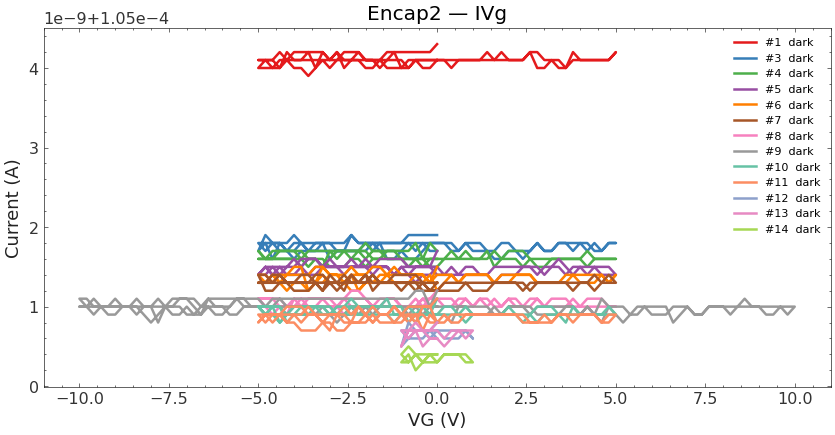

In [21]:
METADATA_CSV = "Serbian_Graphene_metadata.csv"        # path to the table you pasted
BASE_DIR     = Path(".")             # where the raw CSVs live, e.g. "Alisson_04_sept/"
CHIP_NUMBER  = 2.0 
meta = load_and_prepare_metadata(METADATA_CSV, CHIP_NUMBER)
tag = Path(METADATA_CSV).stem
plot_ivg_sequence(meta, BASE_DIR, tag) 

In [30]:
def plot_ivg_selection_multi(
    picks: list[tuple[pl.DataFrame, Path, list[int]]],
    tag: str,
    *,
    legend_label: str = "Chip {chip} #{file_idx}",  # keys: chip, file_idx, session, role, info, VDS
    clip_vg_min: float | None = None,               # crop VG before plotting (for y autoscale on visible range)
    clip_vg_max: float | None = None,
    xlim: tuple[float, float] | None = None,        # force axis if desired
    ylim: tuple[float, float] | None = None,
    dedup_labels: bool = False,                     # ignore repeated legend labels
):
    """
    Plot selected IVg curves (Id vs VG) from multiple chips on ONE figure.

    picks = [
      (meta_df_chip_A, base_dir_chip_A, [idx1, idx2, ...]),
      (meta_df_chip_B, base_dir_chip_B, [idx3, ...]),
      ...
    ]
    """
    plt.figure()
    seen = set()
    total_plotted = 0

    for meta_df, base_dir, file_idxs in picks:
        ivg_rows = (
            meta_df
            .filter((pl.col("proc") == "IVg") & pl.col("file_idx").is_in(file_idxs))
            .sort("file_idx")
        )
        if ivg_rows.height == 0:
            continue

        for row in ivg_rows.iter_rows(named=True):
            p = base_dir / row["source_file"]
            if not p.exists():
                print(f"[warn] missing file: {p}")
                continue

            d = _read_measurement(p)
            if not {"VG", "I"} <= set(d.columns):
                print(f"[warn] {p} lacks VG/I; got {d.columns}")
                continue

            # optional crop by VG so y autoscale reflects the shown region only
            dd = d
            if (clip_vg_min is not None) or (clip_vg_max is not None):
                conds = []
                if clip_vg_min is not None:
                    conds.append(pl.col("VG") >= float(clip_vg_min))
                if clip_vg_max is not None:
                    conds.append(pl.col("VG") <= float(clip_vg_max))
                if conds:
                    dd = d.filter(pl.all_horizontal(conds))
            if dd.height == 0:
                continue

            chip_num = int(row.get("Chip number", -1))
            lbl = legend_label.format(
                chip=chip_num,
                file_idx=int(row["file_idx"]),
                session=int(row.get("session", -1)),
                role=str(row.get("role", "")),
                info=str(row.get("Information", "")),
                VDS=float(row.get("VDS", float("nan"))),
            )

            plot_lbl = lbl
            if dedup_labels and lbl in seen:
                plot_lbl = "_" + lbl  # matplotlib ignores labels starting with "_"
            else:
                seen.add(lbl)

            plt.plot(dd["VG"], dd["I"], label=plot_lbl)
            total_plotted += 1

    if total_plotted == 0:
        print("[warn] nothing plotted (check your IVg file_idx picks)")
        return

    if xlim is not None:
        plt.xlim(*xlim)
    if ylim is not None:
        plt.ylim(*ylim)

    plt.xlabel("VG (V)")
    plt.ylabel("Current (A)")
    plt.title("IVg overlay — multi-chip selection")
    plt.legend(fontsize=8)
    plt.tight_layout()
    out = FIG_DIR / f"IVg_overlay_multichip_{tag}.png"
    plt.savefig(out, dpi=200)
    print(f"saved {out}")


saved figs/IVg_overlay_multichip_chips71_79_custom_ivg.png


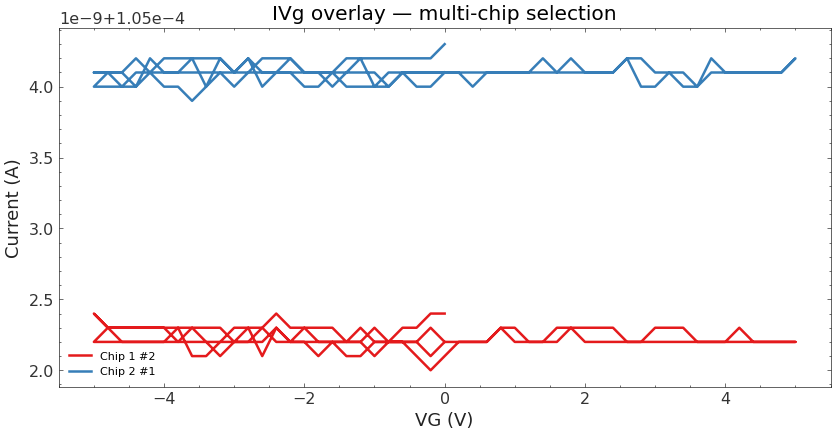

In [31]:
# Load each chip/day separately
meta71_day1 = load_and_prepare_metadata("Serbian_Graphene_metadata.csv", 1.0)
meta79_day2 = load_and_prepare_metadata("Serbian_Graphene_metadata.csv", 2.0)

BASE1 = Path(".")
BASE2 = Path(".")
tag = "chips71_79_custom_ivg"

# Hand-pick IVg runs by their _NN indices
picks = [
    (meta71_day1, BASE1, [2]),  # chip 71: IVg #22 and #26
    (meta79_day2, BASE2, [1]),  # chip 79: IVg #11 and #12
]

# Legend shows chip number + file index
plot_ivg_selection_multi(
    picks, tag,
    legend_label="Chip {chip} #{file_idx}",
    # optional cropping/axes:
    # clip_vg_min=-5.0, clip_vg_max=5.0,
    # xlim=(-6, 6), ylim=(-2e-5, 2e-5),
    dedup_labels=False
)
